# MatchPredictor

### A neural network which predicts the outcomes of Premier League football matches

#### Importing Libraries & Packages

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.utils.data 

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import pandas as pd
import matplotlib.pyplot as plt

from time import time

Microsoft Visual C++ Redistributable is not installed, this may lead to the DLL load failure.
                 It can be downloaded at https://aka.ms/vs/16/release/vc_redist.x64.exe


#### Hyperparameters

In [2]:
# Data HPs
past = 3     # How many past games are taken into account for team form calculations
infer_data_percent = 0.20   # (1-infer_data_percent)*100 = percent of full dataset in training set
test_data_percent = 0.50    # (test_data_percent*infer_data_percent)*100 = percent of data in test set (rest in validation set)

# Training HPs
rseed = 3 
batch_size = 64
lr = 0.1
num_epochs = 13
weight_decay = 0

# Model HPs
input_size = 12
layer_sizes = [32,32,20,3]  # in_size = 12, fc1_size = 32, fc2_size = 32, fc3_size = 20, out_size = 3
act= 1                      # 0 = ReLU,    1 = TanH
loss_fcn_toggle = 0         # 0 = MSELoss, 1 = BCELoss

#### Importing Match Data

In [3]:
# Imported CSVs become pandas' DataFrames

data_20_prem = pd.read_csv("Prem League Match Data\england-premier-league-matches-2019-to-2020-stats.csv")
data_19_prem = pd.read_csv("Prem League Match Data\england-premier-league-matches-2018-to-2019-stats.csv")
data_18_prem = pd.read_csv("Prem League Match Data\england-premier-league-matches-2017-to-2018-stats.csv")
data_17_prem = pd.read_csv("Prem League Match Data\england-premier-league-matches-2016-to-2017-stats.csv")
data_16_prem = pd.read_csv("Prem League Match Data\england-premier-league-matches-2015-to-2016-stats.csv")
data_15_prem = pd.read_csv("Prem League Match Data\england-premier-league-matches-2014-to-2015-stats.csv")
data_14_prem = pd.read_csv("Prem League Match Data\england-premier-league-matches-2013-to-2014-stats.csv")
data_13_prem = pd.read_csv("Prem League Match Data\england-premier-league-matches-2012-to-2013-stats.csv")

data_20_spain = pd.read_csv("La-Liga Match Data\spain-la-liga-matches-2019-to-2020-stats.csv")
data_19_spain = pd.read_csv("La-Liga Match Data\spain-la-liga-matches-2018-to-2019-stats.csv")
data_18_spain = pd.read_csv("La-Liga Match Data\spain-la-liga-matches-2017-to-2018-stats.csv")
data_17_spain = pd.read_csv("La-Liga Match Data\spain-la-liga-matches-2016-to-2017-stats.csv")
data_16_spain = pd.read_csv("La-Liga Match Data\spain-la-liga-matches-2015-to-2016-stats.csv")
data_15_spain = pd.read_csv("La-Liga Match Data\spain-la-liga-matches-2014-to-2015-stats.csv")
data_14_spain = pd.read_csv("La-Liga Match Data\spain-la-liga-matches-2013-to-2014-stats.csv")
data_13_spain = pd.read_csv("La-Liga Match Data\spain-la-liga-matches-2012-to-2013-stats.csv")

data_20_france = pd.read_csv("france-ligue-1-matches-2019-to-2020-stats.csv")
data_19_france = pd.read_csv("france-ligue-1-matches-2018-to-2019-stats.csv")
data_18_france = pd.read_csv("france-ligue-1-matches-2017-to-2018-stats.csv")
data_17_france = pd.read_csv("france-ligue-1-matches-2016-to-2017-stats.csv")
data_16_france = pd.read_csv("france-ligue-1-matches-2015-to-2016-stats.csv")
data_15_france = pd.read_csv("france-ligue-1-matches-2014-to-2015-stats.csv")
data_14_france = pd.read_csv("france-ligue-1-matches-2013-to-2014-stats.csv")

data_20_italy = pd.read_csv("Serie-A Match Data\italy-serie-a-matches-2019-to-2020-stats.csv")
data_19_italy = pd.read_csv("Serie-A Match Data\italy-serie-a-matches-2018-to-2019-stats.csv")
data_18_italy = pd.read_csv("Serie-A Match Data\italy-serie-a-matches-2017-to-2018-stats.csv")
data_17_italy = pd.read_csv("Serie-A Match Data\italy-serie-a-matches-2016-to-2017-stats.csv")
data_16_italy = pd.read_csv("Serie-A Match Data\italy-serie-a-matches-2015-to-2016-stats.csv")
data_15_italy = pd.read_csv("Serie-A Match Data\italy-serie-a-matches-2014-to-2015-stats.csv")
data_14_italy = pd.read_csv("Serie-A Match Data\italy-serie-a-matches-2013-to-2014-stats.csv")

data_20_germany = pd.read_csv("Bundesliga Match Data\germany-bundesliga-matches-2019-to-2020-stats.csv")
data_19_germany = pd.read_csv("Bundesliga Match Data\germany-bundesliga-matches-2018-to-2019-stats.csv")
data_18_germany = pd.read_csv("Bundesliga Match Data\germany-bundesliga-matches-2017-to-2018-stats.csv")
data_17_germany = pd.read_csv("Bundesliga Match Data\germany-bundesliga-matches-2016-to-2017-stats.csv")
data_16_germany = pd.read_csv("Bundesliga Match Data\germany-bundesliga-matches-2015-to-2016-stats.csv")
data_15_germany = pd.read_csv("Bundesliga Match Data\germany-bundesliga-matches-2014-to-2015-stats.csv")
data_14_germany = pd.read_csv("Bundesliga Match Data\germany-bundesliga-matches-2013-to-2014-stats.csv")


data = [data_20_prem, data_19_prem, data_18_prem, data_17_prem, data_16_prem, data_15_prem, data_14_prem, data_13_prem,
        data_20_spain, data_19_spain, data_18_spain, data_17_spain, data_16_spain, data_15_spain, data_14_spain, data_13_spain,
        data_20_france, data_19_france, data_18_france, data_17_france, data_16_france, data_15_france, data_14_france, 
        data_20_italy, data_19_italy, data_18_italy, data_17_italy, data_16_italy, data_15_italy, data_14_italy,
        data_20_germany, data_19_germany, data_18_germany, data_17_germany, data_16_germany, data_15_germany, data_14_germany]

#### DATA PREPROCSESSING  
  
Here we create the inputs for our model from the raw .csv files we collected from *footystats.org*.  
  
- Each season will be represented by a matrix.  
- Each row of this matrix will consist of the inputs that describe a single match to the neural net.  
  
In each row, the entries are as follows:  
*Note: **past** is an integer hyperparameter*  
  
**Index 0**: Home team average goals scored per game over last **past** games.  
**Index 1**:  Home team average goals conceded per game over last **past** games.  
**Index 2**:  Home team pre-match PointsPerGame (only includes current season).  
**Index 3**:  Home team PointsPerGame (includes previous seasons).  
**Index 4**:  Home team average number of shots on target over last **past** games.  
**Index 5**:  Home team average number of corners over last **past** games.  
**Index 6**:  Away team average goals scored per game over last **past** games.  
**Index 7**:  Away team average goals conceded per game over last **past** games.  
**Index 8**:  Away team pre-match PointsPerGame (only includes current season).  
**Index 9**:  Away team PointsPerGame (includes previous seasons).  
**Index 10**:  Away team average number of shots on target over last **past** games.  
**Index 11**:  Away team average number of corners over last **past** games.  
**Index 12 (LABEL)**:  0 if Home Team won, 1 if Away Team won, 2 if Draw. 
  
  
*NOTE: The first "past" weeks from each season cannot be used in training/testing as they have no previous matches to get data from.*

In [4]:
# Set up empty matrices to be filled with INPUTS & LABELS.
# Once filled with values, each row will represent the inputs/label combo that describe a match to the NN.
    
prem_20 = np.zeros((380-(past*10),13))
prem_19 = np.zeros((380-(past*10),13))
prem_18 = np.zeros((380-(past*10),13))
prem_17 = np.zeros((380-(past*10),13))
prem_16 = np.zeros((380-(past*10),13))
prem_15 = np.zeros((380-(past*10),13))
prem_14 = np.zeros((380-(past*10),13))
prem_13 = np.zeros((380-(past*10),13))

spain_20 = np.zeros((380-(past*10),13))
spain_19 = np.zeros((380-(past*10),13))
spain_18 = np.zeros((380-(past*10),13))
spain_17 = np.zeros((380-(past*10),13))
spain_16 = np.zeros((380-(past*10),13))
spain_15 = np.zeros((380-(past*10),13))
spain_14 = np.zeros((380-(past*10),13))
spain_13 = np.zeros((380-(past*10),13))

france_20 = np.zeros((380-(past*10),13))
france_19 = np.zeros((380-(past*10),13))
france_18 = np.zeros((380-(past*10),13))
france_17 = np.zeros((380-(past*10),13))
france_16 = np.zeros((380-(past*10),13))
france_15 = np.zeros((380-(past*10),13))
france_14 = np.zeros((380-(past*10),13))

italy_20 = np.zeros((380-(past*10),13))
italy_19 = np.zeros((380-(past*10),13))
italy_18 = np.zeros((380-(past*10),13))
italy_17 = np.zeros((380-(past*10),13))
italy_16 = np.zeros((380-(past*10),13))
italy_15 = np.zeros((380-(past*10),13))
italy_14 = np.zeros((380-(past*10),13))

germany_20 = np.zeros((306-(past*9),13))
germany_19 = np.zeros((306-(past*9),13))
germany_18 = np.zeros((306-(past*9),13))
germany_17 = np.zeros((306-(past*9),13))
germany_16 = np.zeros((306-(past*9),13))
germany_15 = np.zeros((306-(past*9),13))
germany_14 = np.zeros((306-(past*9),13))


input_seasons = [prem_20, prem_19, prem_18, prem_17, prem_16, prem_15, prem_14, prem_13,
                 spain_20, spain_19, spain_18, spain_17, spain_16, spain_15, spain_14, spain_13,
                 france_20, france_19, france_18, france_17, france_16, france_15, france_14, 
                 italy_20, italy_19, italy_18, italy_17, italy_16, italy_15, italy_14,
                 germany_20, germany_19, germany_18, germany_17, germany_16, germany_15, germany_14]


season_idx = 0
for season in data:
    
    week = past + 1
    input_season = input_seasons[season_idx]
    
    if season_idx < 30: # if any league other than German league...
        weeks_in_season = 38
        
    if season_idx >= 30: # if German league...
        weeks_in_season = 34
    
    while week <= weeks_in_season:
        
        match_count = 0                      # counts up to match_total for each week
        
        if season_idx < 30:
            match_total = 10                 # each week has 10 matches in every league except German
            
        if season_idx >= 30:                 # season 31-37 == German league
            match_total = 9                  # German league has 9 matches in a given week
        
        
        row_idx = (week-1)*match_total       # index of the first match of new week

        
        while match_count < match_total:
    
            match = season.iloc[[row_idx]]                     # saving current match
            
             # getting match LABEL (match result)
            if (match.iat[0,12] > match.iat[0,13]):            
                    result = 0   # home team win
            elif (match.iat[0,12] < match.iat[0,13]):
                    result = 1   # away team win
            else:
                    result = 2   # draw
                    
            
            home_team = season.at[row_idx,'home_team_name']    # saving home team name
            away_team = season.at[row_idx,'away_team_name']    # saving away team name
            
            total_home_goals = 0                               # counts total goals scored by home team over "past" matches
            total_away_goals = 0                               # counts total goals scored by away team over "past" matches
            
            total_home_conceded = 0                            # counts total goals scored against home team over "past" matches 
            total_away_conceded = 0                            # counts total goals scored against away team over "past" matches
            
            total_home_shotson = 0                             # counts total shots on target taken by home team over...
            total_away_shotson = 0                             # counts total shots on target taken by away team over...
            
            total_home_corners = 0                             # counts total corners taken by home team over...
            total_away_corners = 0                             # counts total corners taken by away team over...
            
            home_PPG_pre = match.iat[0,8]                      # home team pre-match points per game (PPG)
            away_PPG_pre = match.iat[0,9]                      # away team pre-match points per game (PPG)
            
            
            previous = 1                                       # counts up to "past"
            
            
            while previous <= past:

                home_match_prev = season.loc[(season['home_team_name'] == home_team) & (season['Game Week'] == week-previous)]   # picking out home team's previous match
                h_sc_idx = 12       # home team score index
                h_shon_idx = 32     # home shots on target index
                h_corn_idx = 20     # home corners index
                h_ppg_idx = 10
                
                away_match_prev = season.loc[(season['away_team_name'] == away_team) & (season['Game Week'] == week-previous)]   # picking out away team's previous match
                a_sc_idx = 13       # away team score index
                a_shon_idx = 33     # away team shots on target index
                a_corn_idx = 21     # away corners index
                a_ppg_idx = 11
                
                # if home team name was not found in 'home_team_name' column...
                if (home_match_prev.size == 0):
                    home_match_prev = season.loc[(season['away_team_name'] == home_team) & (season['Game Week'] == week-previous)]   # picking out home team's previous match
                    h_sc_idx = 13      # home team score index
                    h_shon_idx = 33    # home shots on target index
                    h_corn_idx = 21    # home corners index
                    h_ppg_idx = 11
                    
                # if away team name was not found in 'away_team_name' column...
                if (away_match_prev.size == 0):
                    away_match_prev = season.loc[(season['home_team_name'] == away_team) & (season['Game Week'] == week-previous)]   # picking out away team's previous match
                    a_sc_idx = 12      # away team score index
                    a_shon_idx = 32    # away team shots on target index
                    a_corn_idx = 20    # away corners index
                    a_ppg_idx = 10
                    
                # if loop is 1 match in the past...   
                if previous == 1:
                    home_PPG = home_match_prev.iat[0,h_ppg_idx]
                    away_PPG = away_match_prev.iat[0,a_ppg_idx]
                    
                #print(home_team, 'goals scored in week', week-previous, '= ', home_match_prev.iat[0,h_sc_idx])
                total_home_goals += home_match_prev.iat[0,h_sc_idx]
                total_away_goals += away_match_prev.iat[0,a_sc_idx]
                
                #print(home_team, 'goals conceded in week', week-previous, '=', home_match_prev.iat[0,a_sc_idx])
                total_home_conceded += home_match_prev.iat[0,a_sc_idx]
                total_away_conceded += away_match_prev.iat[0,h_sc_idx]
                
                total_home_shotson += home_match_prev.iat[0,h_shon_idx]
                total_away_shotson += away_match_prev.iat[0,a_shon_idx]
                
                total_home_corners += home_match_prev.iat[0,h_corn_idx]
                total_away_corners += away_match_prev.iat[0,a_corn_idx]
                
                
                previous += 1

            in_idx = row_idx - (past*match_total)
            input_season[in_idx][0] = total_home_goals/past          # input INDEX 0 (home team avg. goals over "past")
            input_season[in_idx][1] = total_home_conceded/past       # input INDEX 1 (home team avg. conceded goals over "past")
            input_season[in_idx][2] = home_PPG_pre                   # input INDEX 2 (home team pre-match PPG: PPG in current season)
            input_season[in_idx][3] = home_PPG                       # input INDEX 3 (home team PPG including past seasons)
            input_season[in_idx][4] = total_home_shotson/past        # input INDEX 4 (home team avg. shots on target over "past")
            input_season[in_idx][5] = total_home_corners/past        # input INDEX 5 (home team avg. corner kicks over "past")
            input_season[in_idx][6] = total_away_goals/past          # input INDEX 6 (away team avg. goals over "past")
            input_season[in_idx][7] = total_away_conceded/past       # input INDEX 7 (away team avg. conceded goals over "past")
            input_season[in_idx][8] = away_PPG_pre                   # input INDEX 8 (away team pre-match PPG: PPG in current season)
            input_season[in_idx][9] = away_PPG                       # input INDEX 9 (away team PPG including past seasons)
            input_season[in_idx][10] = total_away_shotson/past       # input INDEX 10 (away team avg. shots on target over "past")
            input_season[in_idx][11] = total_away_corners/past       # input INDEX 11 (away team avg. corner kicks over "past")
            input_season[in_idx][12] = result                        # label INDEX 12 (match result)
            
            row_idx += 1
            match_count += 1

        week += 1
        
    season_idx += 1
    

# SEASONS 1-8    ->  PREMIER LEAGUE (England)
# SEASONS 9-16   ->  LA LIGA        (Spain)
# SEASONS 17-23  ->  LIGUE 1        (France)
# SEASONS 24-30  ->  SERIE-A        (Italy)
# SEASONS 31-37  ->  BUNDESLIGA     (Germany)

In [5]:
# Joining all season input data into one dataset
data_full_np = np.concatenate((input_seasons), axis=0)

# Turn numpy array back into pd.DataFrame
columns = ['h_goals','h_conceded','h_prePPG','h_avgPPG','h_shotsOn','h_corners',
           'a_goals','a_conceded','a_prePPG','a_avgPPG','a_shotsOn','a_corners',
           'outcome']

data_full = pd.DataFrame(data_full_np, columns=columns)

#Print 'outcome' column sums to determine dataset balance
print('The numbers of match outcomes (Home Team Wins, Away Team Wins, Draws):\n', data_full["outcome"].value_counts())

#============================ BALANCE THE DATASET ==========================
# draws are the under-represented class, so...
# set home wins count = draws count
# set away wins count = draws count

data_full_home  = data_full[data_full["outcome"]==0.0]
data_full_away = data_full[data_full["outcome"]==1.0]
data_full_tie = data_full[data_full["outcome"]==2.0]

data_full_home = data_full_home.sample(len(data_full_tie), random_state=1)
data_full_away = data_full_away.sample(len(data_full_tie), random_state=1)



subsets = [data_full_home,data_full_away,data_full_tie]
data_full = pd.concat(subsets)
print(data_full["outcome"].value_counts(),'\n')

data_full_np = data_full.values

#==========================================================================

# Get a better idea of what our data looks like BEFORE NORMALIZATION
def verbose_print(data):     # helper function
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(data.head())
       
# print("\n \n Data characteristics:")
# verbose_print(data_full.describe())

# Turn 'outcome' column values into one hot-encoded form
lb = LabelBinarizer()
y = lb.fit_transform(data_full_np[:,12])   # y is vector of 1-hot encoded labels

#y = data_full_np[:,12]
#X = data_full_np[:,:12]                    # x is matrix of inputs (need to be normalized still)

# Normalize continuous inputs
X = data_full.drop(columns=['outcome'])


for feature in X:
  mean = X[feature].mean()
  std = X[feature].std()
  X[feature] = X[feature] - mean
  X[feature] = X[feature]/std

X = X.values
X = train_test_split(X,test_size=infer_data_percent,random_state=1)
y = train_test_split(y,test_size=infer_data_percent,random_state=1)

X_train = X[0]  # extracting training inputs
y_train = y[0]  # extracting training labels
X_infer = train_test_split(X[1],test_size = test_data_percent,random_state=1) # splitting inputs into validation and test sets
y_infer = train_test_split(y[1],test_size = test_data_percent,random_state=1) # splitting labels into validation and test sets

The numbers of match outcomes (Home Team Wins, Away Team Wins, Draws):
 0.0    5654
1.0    3643
2.0    3156
Name: outcome, dtype: int64
2.0    3156
1.0    3156
0.0    3156
Name: outcome, dtype: int64 



## Multi-Layer Perceptron Model

In [6]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self, input_size, layer_sizes, act):
        
        # Current parameters are:
        # input_size = size of input data vector
        # layer_sizes = list of each layer size, last layer size MUST = 3, ex: [32,32,20,3]
        
        super(MultiLayerPerceptron, self).__init__()
        
        # setting layer sizes
        self.linears = nn.ModuleList()
        self.linears.append(nn.Linear(input_size,layer_sizes[0]))    # first layer created manually
        for k in range(len(layer_sizes)-1):
            self.linears.append(nn.Linear(layer_sizes[k], layer_sizes[k+1])) # creating all other layers
            
        # setting activation function
        if act == 0:
          self.act = nn.ReLU()
        elif act == 1:  
          self.act = nn.Tanh()
        
        self.out = nn.Softmax(dim=1)

        ''' # manual method
        self.fc2 = nn.Linear(32,32)
        self.fc3 = nn.Linear(32,20)
        self.fc4 = nn.Linear(20,3) 
        '''

    def forward(self, x):
        
        layer_count = len(self.linears)
        
        for i in range(layer_count-1):
            x = self.act(self.linears[i](x))
        
        x = self.out(self.linears[layer_count-1](x))
      
        ''' # manual method
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        '''
        return x

### Helper Functions

#### Dataloader creation


In [7]:
# MatchDataset turns matrix-style datasets into map-style datasets
class MatchDataset(torch.utils.data.Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index],self.y[index]
    

def load_data(batch_size):

    train_dataset = MatchDataset(X_train,y_train)
    valid_dataset = MatchDataset(X_infer[0],y_infer[0])
    test_dataset = MatchDataset(X_infer[1],y_infer[1])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

    return train_loader, valid_loader, test_loader





#### Get prediction from output

In [8]:
def get_preds(z):
  
  out = np.zeros(z.shape)
  #inputs: output of model
  #outputs: corresponding output to prediction
  max_idxs = torch.max(z,1)[1]
  for entry,idx in enumerate(max_idxs,0):
      for val in range(3):
        if val == idx:
          out[entry][val] = 1

  return out

#### Accuracy function

In [9]:
def accuracy(preds, labels):
    #inputs: preds: array, labels:array 
    #output: overall accuracy
    
    correct = 0
    
    '''   # for BCEwithLogitsLoss
    for batch in range(len(preds)):
        idx = labels[batch].int()
        if (preds[batch][idx] == 1):
            correct += 1
    '''
    for batch in range(len(preds)):
        for i in range(3):
            if (preds[batch][i] == 1) and (labels[batch][i] == 1):
                correct += 1     
    
    return (correct/len(preds))

#### Validate 

In [10]:
def validate(model,val_loader,loss_fcn,epoch_train):
    
    mini_conf_matrix = [[0]*3]*3
    
    val_acc=[]
    val_loss=[]

    for i,data in enumerate(val_loader,0): #iterate over val_loader, start idx=0

        inputs,labels = data

        z = model(inputs.float())  #z is size=3 

        preds = get_preds(z) #preds used for accuracy

        loss = loss_fcn(input=z, target=labels.float())  # FOR MSE LOSS

        val_acc.append(accuracy(preds,labels))
        val_loss.append(loss.item())

        if epoch_train > 1:
            labels_true = np.argmax(labels, axis=1)
            labels_pred = np.argmax(preds, axis=1)    
            mini_conf_matrix += confusion_matrix(labels_true, labels_pred, labels=[0,1,2])
       
    ValLoss = sum(val_loss)/len(val_loss)
    ValAcc = sum(val_acc) / len(val_acc)
  
    return ValAcc, ValLoss, mini_conf_matrix

In [11]:
def test(model,test_loader,loss_fcn):
    
    mini_conf_matrix = [[0]*3]*3
    
    val_acc=[]
    val_loss=[]
    for epoch in range(0,20):
        for i,data in enumerate(test_loader,0): #iterate over val_loader, start idx=0

            inputs,labels = data

            z = model(inputs.float())  #z is size=3 

            preds = get_preds(z) #preds used for accuracy

            loss = loss_fcn(input=z, target=labels.float())  # FOR MSE LOSS

            val_acc.append(accuracy(preds,labels))
            val_loss.append(loss.item())


            labels_true = np.argmax(labels, axis=1)
            labels_pred = np.argmax(preds, axis=1)    
            mini_conf_matrix += confusion_matrix(labels_true, labels_pred, labels=[0,1,2])

        ValLoss = sum(val_loss)/len(val_loss)
        ValAcc = sum(val_acc) / len(val_acc)
  
    return ValAcc, ValLoss, mini_conf_matrix

#### Plotting Function

In [12]:
def plot(epoch, train_var, val_var,xlabel,ylabel):
    plt.plot(epoch, train_var, label = 'train')
    plt.plot(epoch, val_var, label = 'validation')
    plt.title(str(ylabel) + ' vs. '+ str(xlabel))
    plt.xlabel(str(xlabel))
    plt.ylabel(str(ylabel))
    plt.legend()
    plt.show()

#### MLP loader

In [13]:
def load_MLP(lr):
    
    #add optimizer,loss functions as a hyperparameters
    model = MultiLayerPerceptron(input_size,layer_sizes,act)
    optimizer = torch.optim.SGD(model.parameters(),lr=lr,weight_decay=weight_decay)

    if loss_fcn_toggle == 0:
        loss_fcn = nn.MSELoss()
    if loss_fcn_toggle == 1:
        loss_fcn = nn.BCELoss()
    
    return model,optimizer,loss_fcn

##Training Loop

Epoch: 1
train acc: 0.39025496562261264
val acc: 0.4493464052287582
train loss: 0.21971916000382238
val loss: 0.21564962863922119
Epoch: 2
train acc: 0.4507734912146677
val acc: 0.4704452614379085
train loss: 0.21259450762211776
val loss: 0.20920202235380808
Epoch: 3
train acc: 0.4610150878533231
val acc: 0.4709763071895425
train loss: 0.20805505656895518
val loss: 0.20585329830646515
Epoch: 4
train acc: 0.4652525783040489
val acc: 0.47383578431372547
train loss: 0.20628636299061173
val loss: 0.2045310656229655
Epoch: 5
train acc: 0.46960943468296407
val acc: 0.4761846405228758
train loss: 0.20528928346994543
val loss: 0.20425807734330495
Epoch: 6
train acc: 0.47131636745607336
val acc: 0.4772058823529412
train loss: 0.20505487042314866
val loss: 0.20427534878253936
Epoch: 7
train acc: 0.46944232238349887
val acc: 0.48425245098039216
train loss: 0.2051553952844203
val loss: 0.20369574228922527
Epoch: 8
train acc: 0.4739901642475172
val acc: 0.47877859477124185
train loss: 0.20491178008

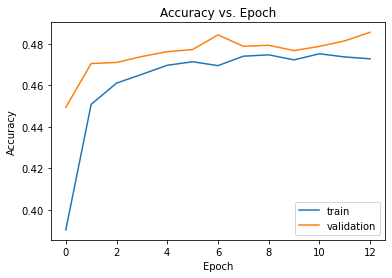

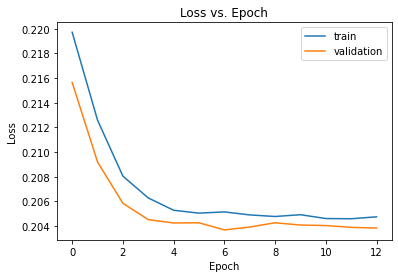

Max training accuracy 0.4751599503437739
Min training loss 0.20460061766520268 

Max Validation accuracy 0.4855392156862745
Min Validation loss 0.20369574228922527 

Test accuracy 0.47487108479755535
Test loss 0.20433433633141157 


 FINAL CONFUSION MATRIX: 
 [[29040 10920 10540]
 [10780 29400 10160]
 [18360 18800 13480]]


In [14]:
def train(rseed,lr,num_epochs):

    torch.manual_seed(rseed)

    model,optimizer,loss_fcn = load_MLP(lr)   #initialize model
    
    train_loader, valid_loader, test_loader = load_data(batch_size) # get dataloaders

    # records for plotting 
    TrainAccRec = []
    TrainLossRec = []
    ValAccRec = []  
    ValLossRec = []
    
    conf_matrix = [[0]*3]*3
    
    tic = time()
 
# ========================================TRAINING LOOP =========================================# 
    for epoch in range(0,num_epochs):
        batch_count = 0
        train_acc_sum = 0
        train_loss_sum = 0
        for i,data in enumerate(train_loader,0): #iterate over train_loader, start idx=0
            inputs,labels = data

            optimizer.zero_grad()  #initialize the gradients to zero  

            z = model(inputs.float())  #z is size=3

            preds = get_preds(z) #preds used for accuracy
            
            loss = loss_fcn(input=z, target=labels.float())

            loss.backward() #get gradients 

            optimizer.step() #update parameters

            train_acc = accuracy(preds,labels)
            train_loss = loss.item()

            #add to overall records
            train_acc_sum += train_acc
            train_loss_sum += train_loss
            
            batch_count += 1

        TrainAccRec.append(train_acc_sum/batch_count)
        TrainLossRec.append(train_loss_sum/batch_count)
        val_acc, val_loss, mini_conf_matrix = validate(model,valid_loader,loss_fcn,epoch)
        ValAccRec.append(val_acc)
        ValLossRec.append(val_loss)
        #conf_matrix = np.add(conf_matrix, mini_conf_matrix)
        #print(conf_matrix)
        
        print("Epoch:",epoch+1)
        print("train acc:",train_acc_sum/batch_count)
        print("val acc:",val_acc)
        print("train loss:", train_loss_sum/batch_count)
        print("val loss:", val_loss)

    toc = time()
    print("Total training time:", toc-tic)

    test_acc, test_loss, conf_matrix = test(model,train_loader,loss_fcn)

    
    #plottting
    e = np.arange(0,num_epochs)
    plot(e,TrainAccRec,ValAccRec,'Epoch','Accuracy')
    plot(e,TrainLossRec,ValLossRec,'Epoch','Loss')
    print("Max training accuracy",max(TrainAccRec))
    print("Min training loss",min(TrainLossRec),"\n")
    print("Max Validation accuracy",max(ValAccRec))
    print("Min Validation loss",min(ValLossRec),"\n")
    print("Test accuracy",test_acc)
    print("Test loss",test_loss,"\n")
    
    print('\n FINAL CONFUSION MATRIX: \n',conf_matrix)
    
    #torch.save(model.state_dict(),'MatchPredictor_WeightDecayBest.pt')
 

train(rseed,lr,num_epochs)  